In [1]:
# IMPORTS

import os
import json
import datetime
from collections import defaultdict, deque
import re, string, unicodedata
import nltk
import statistics
from nltk.util import ngrams
from nltk import sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import itertools
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import words
from collections import Counter
import operator
import pprint
import datetime
import matplotlib.dates as mdates

In [2]:
# HELPER FUNCTIONS

def notin(target, comparelist):
    for element in comparelist:
        if element in target:
            return False
    return True

def preprocess(words):
    words = words.lower()
    # weird thing with apostrophe showing up as this unicode string
    words = re.sub("\u00e2\u0080\u0099", "'", words)
    # filter out all remaining Unicode, TODO: maybe want to translate these into emojis?
    words = words.encode("ascii", "ignore").decode("UTF-8")
    return words

def print_sorted_dict(d, first_x=None):
    sorted_keys = sorted(d, key=d.get, reverse=True)
    for i, key in enumerate(sorted_keys):
        if first_x is not None and i >= first_x:
            break
        print(f"Rank {i+1}:", key, d[key])
    return sorted_keys

def is_contraction(word):
    if "'" in word:
        split_word = word.split("'")
        if len(split_word) > 1 and split_word[0] in english_words:
            return True
    return False

terms_to_include = set(["kys"])
def exclude_word(word):
    return (len(word) < 1 or word in english_words or word.isdigit() 
            or is_contraction(word) or word in standard_contractions) and (word not in terms_to_include)

pp = pprint.PrettyPrinter(indent=4)
def print_term_to_senders():
    pp.pprint(term_to_senders)

In [3]:
# define some utility sets

standard_contractions = set(["aren't", "can't", "could've", "couldn't", "didn't", 
                "doesn't", "don't", "hadn't", "hasn't", "haven't", "he'd", "he'll", "he's", 
                "how'd", "how'll", "how's", "i'd", "i'll", "i'm", "i've", "isn't", "it'd", 
                "it'll", "it's", "let's", "might've", "mightn't", "must've", 
                "mustn't", "needn't", "o'clock", "she'd", "she'll", "she's", 
                "should've", "shouldn't", "that'd", "that's", "there'd", 
                "there's", "they'd", "they'll", "they're", "they've", "wasn't", 
                "we'd", "we'll", "we're", "we've", "weren't", "what'll", "what're", "what's",
                "what've", "when's", "when've", "where'd", "where's", "where've", "who'll", 
                "who's", "who've", "why's", "won't", "would've", 
                "wouldn't", "you'd", "you'll", "you're", "you've"])

# add in all contractions without the apostrophes also
new_contractions = set()
for contraction in standard_contractions:
    new_contractions.add(contraction.replace("'", ""))

standard_contractions = standard_contractions.union(new_contractions)

In [4]:
# define lemmatizer
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# sample use cases
# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()

# 2. Lemmatize Single Word with the appropriate POS tag
# word = 'feet'
# print(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

# 3. Lemmatize a Sentence with the appropriate POS tag
# sentence = "The striped bats are hanging on their feet for best"
# print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)])

Rank 1: Dan J Chong 35953
Rank 2: Aneree Rathod 20985
Rank 3: Sakshi Roongta 18177
Rank 4: Roshni Banerjee 14926
Rank 5: Tina Lu 13086
Rank 6: Aditya Parthasarathy 12261
Rank 7: Enoch Jiang 8339
Rank 8: Allison Lin 6880
Rank 9: Paschal Park 4658
Rank 10: Cat Ngoc Nguyen 4342
Rank 11: Winston Huang 4183
Rank 12: Alice Zhang 3751
Rank 13: Julian Vallyeason 3547
Rank 14: Victor Zhang 3027
Rank 15: Stephen Yan 2584
Rank 16: Alyssa Rust 2412
Rank 17: Victor Su-Ortiz 2367
Rank 18: Maya Jodidio 2260
Rank 19: Jeffrey Ho 2190
Rank 20: Daniel Chan 2074
Rank 21: Avi 2042
Rank 22: Renny Ma 2022
Rank 23: Gowtham Balaji 1790
Rank 24: Justin Kim 1778
Rank 25: Derek Kuldinow 1750
Rank 26: Tom Lynch 1487
Rank 27: Samantha Liu 1483
Rank 28: Jason Xu 1466
Rank 29: Vivian Xu 1378
Rank 30: Ian K. Hou 1299
Rank 31: Grace Ding 1264
Rank 32: Daniel Yang 1173
Rank 33: Wenhuang Zeng 1151
Rank 34: Chloe Jen 1146
Rank 35: Tyler Jiang 1135
Rank 36: Ray Sy 1097
Rank 37: Eric Mi 1054
Rank 38: Amy Li 950
Rank 39: Jas

Alice Zhang
Grace Ding
Dan J Chong
Aditya Parthasarathy
Maya Jodidio
Jason Xu
Tina Lu
Allison Lin
Jeffrey Ho
Tom Lynch
Aneree Rathod
Julian Vallyeason
Roshni Banerjee
Sakshi Roongta
Daniel Chan
Vivian Xu
Victor Su-Ortiz
Enoch Jiang


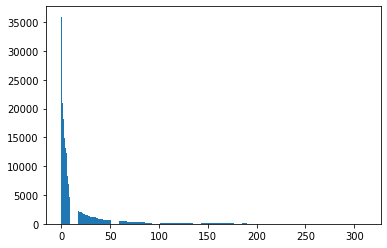

In [5]:
# extract message dictionaries

msg_dir = "/home/lhuang21/Documents/SideProjects/Grapevine/facebook-lawrenceh1850/messages/inbox"
account_user_name = "Lawrence Huang"

# list of message dictionaries of interest
conv_dicts = {}
friend_to_num_msgs = defaultdict(lambda: 0)

for dir_name in os.listdir(msg_dir):
    if not dir_name.startswith("."):
        file_path = os.path.join(msg_dir, dir_name, 'message_1.json')
        
        # make sure file exists
        if os.path.exists(file_path):
            json_dict = json.load(open(file_path, 'r'))

            # only look at DM's with more than 10 messages
            if len(json_dict['participants']) == 2 and len(json_dict['messages']) > 10:
                for friend_dict in json_dict['participants']:
                    friend_name = friend_dict["name"]
                    if friend_name != account_user_name:
                        num_msgs = len(json_dict['messages'])
                        friend_to_num_msgs[friend_name] = num_msgs

# print counts of individual messages
sorted_names = print_sorted_dict(friend_to_num_msgs)

plt.bar(list(range(len(sorted_names))), [friend_to_num_msgs[name] for name in sorted_names])
    
# top ten percentile of friends        
top_ten_percentile = sorted_names[:len(sorted_names) // 10]

for dir_name in os.listdir(msg_dir):
    if not dir_name.startswith("."):
        file_path = os.path.join(msg_dir, dir_name, 'message_1.json')
        
        # make sure file exists
        if os.path.exists(file_path):
            json_dict = json.load(open(file_path, 'r'))

            # only look at DM's with more than 10 messages
            if len(json_dict['participants']) == 2 and len(json_dict['messages']) > 10:
                for friend_dict in json_dict['participants']:
                    friend_name = friend_dict["name"]
                    if friend_name != account_user_name and friend_name in top_ten_percentile:
                        print(friend_name)
                        conv_dicts[friend_name] = json_dict

In [6]:
# counts number of words

friend_to_words = defaultdict(lambda: 0)

for friend_name, conv_dict in conv_dicts.items():
#     print("Friend name:", friend_name)
#     print("=" * 50)
    
    messages = conv_dict["messages"]
    for (index, msg) in enumerate(messages):
        try:
            content = msg['content']
            tok_content = content.split()
            friend_to_words[friend_name] += len(tok_content)
        except KeyError:
            pass
_ = print_sorted_dict(friend_to_words, first_x=25)

Rank 1: Aneree Rathod 199846
Rank 2: Dan J Chong 194411
Rank 3: Sakshi Roongta 124517
Rank 4: Tina Lu 117387
Rank 5: Aditya Parthasarathy 80846
Rank 6: Roshni Banerjee 56153
Rank 7: Enoch Jiang 48069
Rank 8: Allison Lin 41070
Rank 9: Cat Ngoc Nguyen 23692
Rank 10: Paschal Park 22768
Rank 11: Julian Vallyeason 20835
Rank 12: Alice Zhang 19720
Rank 13: Winston Huang 18893
Rank 14: Renny Ma 17742
Rank 15: Stephen Yan 16289
Rank 16: Alyssa Rust 16281
Rank 17: Victor Zhang 16076
Rank 18: Maya Jodidio 15477
Rank 19: Avi 14259
Rank 20: Daniel Chan 14117
Rank 21: Victor Su-Ortiz 12500
Rank 22: Derek Kuldinow 11276
Rank 23: Jeffrey Ho 10436
Rank 24: Samantha Liu 9506
Rank 25: Gowtham Balaji 8853


In [7]:
# monogram/trigram/bigram extraction

from nltk.corpus import words
import pickle 
import os

def add_term_timestamp(term_dict, term, friend_name, sender_name, timestamp_ms):
    # figure out which person didn't send it
    non_sender = friend_name
    if friend_name == sender_name:
        non_sender = account_user_name

    # term doesn't exist in dict
    if term_dict.get(term) is None:
        term_dict[term] = {
            friend_name: {
                sender_name: deque([timestamp_ms]),
                non_sender: deque([])
            }
        }
    else: # term exists in dict
        if term_dict[term].get(friend_name) is None: # not yet found in this conversation
            term_dict[term][friend_name] = { sender_name: deque([timestamp_ms]), non_sender: deque([]) }
        else:
            # prepend because the file starts from the newest messages
            term_dict[term][friend_name][sender_name].appendleft(timestamp_ms)

pickled_dict_fname = "term_to_senders_dict"
redo_analysis = True

term_to_senders = {}
# {
#     "<term>": {
#         "<friend_name>": 
#             {
#                  "<friend_name>": [<list of timestamps in ms>],
#                  "<account_user_name>": [<list of timestamps in ms>]
#             }
#         ....
#     },
#     ....
# }
sender_to_term_count_fname = "sender_to_term_count"

# helper methods to allow sender_to_term_count to be pickle-able
def return_zero():
    return 0
def return_dd():    
    return defaultdict(return_zero)

sender_to_term_count = defaultdict(return_dd)
# {
#   "<user_name>"": {
#     "<term>": count,
#     ...
#   }
# }

if os.path.exists(pickled_dict_fname):
    print("Term to senders dictionary exists already.")
    user_input = None
    while user_input is None or not (user_input == "y" or user_input == "n"):
        user_input = input("Redo analysis (y/n)? ").lower()
    if user_input == "y":
        redo_analysis = True
    else:
        redo_analysis = False

if not redo_analysis:
    print("Loading dictionaries from file...")
    term_to_senders = pickle.load(open(pickled_dict_fname, "rb")) 
    sender_to_term_count = pickle.load(open(sender_to_term_count_fname, "rb")) 
    print("Dictionaries loaded")
else:
    print("Redoing analysis...")
    
    #  get monogram/bigram/trigrams
    english_words = set(words.words())

    for friend_name, conv_dict in conv_dicts.items():
        print("Conversation with", friend_name)
        print("=" * 50)

        messages = conv_dict["messages"]
        for (index, msg) in enumerate(messages): 
            try:
                sender_name = msg["sender_name"]
                content = msg["content"]
                timestamp_ms = msg["timestamp_ms"]

                if notin(content, ["You are now connected on Messenger.", "Say hi to your new Facebook friend"]):
                    content = preprocess(content)

    #                 alternate ways of tokenizing
    #                 tok_content = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(content)]
    #                 tok_content = nltk.word_tokenize(content)

                    tok_content = content.split()

                    # monograms
                    for word in tok_content:
                        word = word.strip(string.punctuation)
                        if len(word) > 0:
                            # only lemmatize if this was not a hand-picked word
                            if word not in terms_to_include: 
                                word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                            if not exclude_word(word):
                                add_term_timestamp(term_to_senders, word, friend_name, sender_name, timestamp_ms)

                    # bigrams
                    for (tok1, tok2) in ngrams(tok_content, 2):
                        tok1 = tok1.strip(string.punctuation)
                        tok2 = tok2.strip(string.punctuation)
                        if (exclude_word(tok1) and exclude_word(tok2)
                            or (tok1.isdigit() or tok2.isdigit())):
                            continue
                        else:
                            add_term_timestamp(term_to_senders, (tok1, tok2), friend_name, sender_name, timestamp_ms)

                    # trigrams
                    for (tok1, tok2, tok3) in ngrams(tok_content, 3):
                        tok1 = tok1.strip(string.punctuation)
                        tok2 = tok2.strip(string.punctuation)
                        tok3 = tok3.strip(string.punctuation)
                        num_stop = 0
                        if exclude_word(tok1):
                            num_stop += 1
                        if exclude_word(tok2):
                            num_stop += 1
                        if exclude_word(tok3):
                            num_stop += 1

                        if num_stop >= 2:
                            continue
                        else:
                            add_term_timestamp(term_to_senders, (tok1, tok2, tok3), friend_name, sender_name, timestamp_ms)
            except KeyError:
                # messages that are just photos don't have a content key
                pass
    
    # FILTER term_to_senders based on occurrence frequency
    # TODO: sort by occurrence, and see the cutoff filtering based on something besides frequency

    terms_to_delete = set()
    term_to_count = defaultdict(lambda: 0)

    for term in term_to_senders:
        num_usages = 0
        for friend_name in term_to_senders[term]:
            # count up usages for both user and friends
            for user_name in term_to_senders[term][friend_name]:
                timestamp_count = len(term_to_senders[term][friend_name][user_name])
                num_usages += timestamp_count
                sender_to_term_count[user_name][term] += timestamp_count
        if num_usages < 4:
            terms_to_delete.add(term)
        else:
            term_to_count[term] += num_usages
        for sender in sender_to_term_count:
            try:
                if sender_to_term_count[sender][term] < 4:
                    del sender_to_term_count[sender][term]
            except KeyError:
                pass
    for term in terms_to_delete:
         del term_to_senders[term]
    print(len(term_to_senders)) # should be 9998
    
    print("Saving dictionary to file")
    pickle.dump(term_to_senders, open(pickled_dict_fname, "wb"))
    pickle.dump(sender_to_term_count, open(sender_to_term_count_fname, "wb"))

Term to senders dictionary exists already.
Redo analysis (y/n)? n
Loading dictionaries from file...
Dictionaries loaded


In [8]:
# prints slang ranked by frequency across all users
# _ = print_sorted_dict(term_to_count)

# prints slang ranked by frequency for a single user
friend_name = "Dan J Chong"
freq_per_friend = print_sorted_dict(sender_to_term_count[friend_name])
# print_sorted_dict(sender_to_term_count["Lawrence Huang"])

Rank 1: lol 1242
Rank 2: fuck 454
Rank 3: ok 401
Rank 4: shit 263
Rank 5: pm 263
Rank 6: 2/15/16 258
Rank 7: ('pm', 'paschal') 258
Rank 8: gonna 237
Rank 9: wanna 151
Rank 10: wtf 148
Rank 11: lmao 130
Rank 12: kid 127
Rank 13: okay 125
Rank 14: idk 124
Rank 15: btw 117
Rank 16: nah 110
Rank 17: teh 103
Rank 18: lawrence 102
Rank 19: lmfao 100
Rank 20: xd 90
Rank 21: aditya 86
Rank 22: ('im', 'gonna') 80
Rank 23: rofl 75
Rank 24: ('lol', 'i') 62
Rank 25: email 57
Rank 26: mom 56
Rank 27: fk 55
Rank 28: addy 54
Rank 29: kinda 53
Rank 30: avi 53
Rank 31: spanish 52
Rank 32: ('holy', 'shit') 52
Rank 33: ahve 52
Rank 34: rutgers 51
Rank 35: ('the', 'fuck') 51
Rank 36: liek 51
Rank 37: jsut 51
Rank 38: korean 50
Rank 39: hte 48
Rank 40: hw 45
Rank 41: pls 44
Rank 42: kys 43
Rank 43: ('oh', 'shit') 41
Rank 44: haha 41
Rank 45: fuckign 41
Rank 46: km 40
Rank 47: jk 37
Rank 48: ('you', 'guys') 36
Rank 49: ('wanted', 'to') 35
Rank 50: omg 35
Rank 51: bro 34
Rank 52: woudl 34
Rank 53: hang 33
Ra

KeyboardInterrupt: 

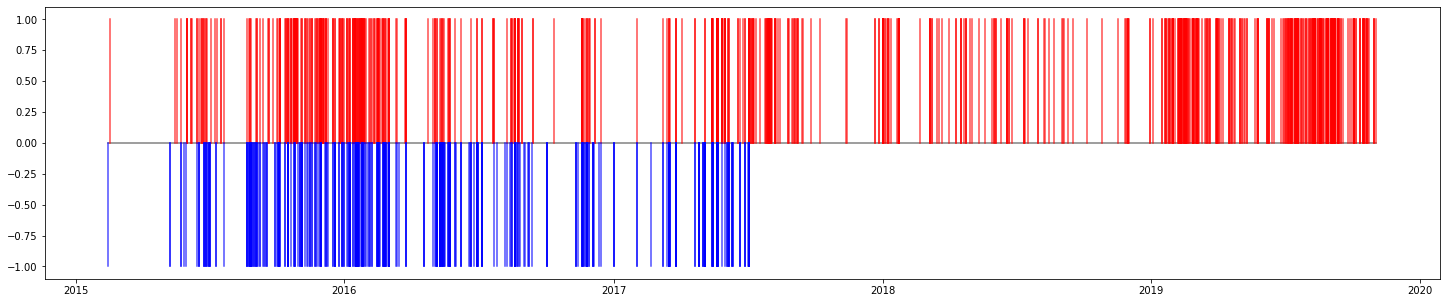

In [9]:
def plot_term_mentions(term_examined, friend_name):
    # DO NOT MODIFY
    # =================================
    account_user_name = "Lawrence Huang"
    # =================================
    sample_dict = term_to_senders[term_examined][friend_name]

    other_mentions = [datetime.datetime.utcfromtimestamp(i / 1000).replace(tzinfo=datetime.timezone.utc) for i in sample_dict[friend_name]]
    me_mentions = [datetime.datetime.utcfromtimestamp(i / 1000).replace(tzinfo=datetime.timezone.utc) for i in sample_dict[account_user_name]]
#     print(len(other_mentions + me_mentions))
    # This tutorial as reference: https://matplotlib.org/3.0.0/gallery/lines_bars_and_markers/timeline.html

    fig, ax = plt.subplots(figsize=(25, 5))

    # Create the base line
    start = min(me_mentions + other_mentions)
    stop = max(me_mentions + other_mentions)
    ax.plot((start, stop), (0, 0), 'k', alpha=.5)

    # Iterate through releases annotating each one
    for i, date in enumerate(me_mentions):
        ax.plot((date, date), (0, 1), c='r', alpha=.7, label=f"{account_user_name}" if i == 0 else "_nolegend_")
    for i, date in enumerate(other_mentions):
        # Plot a line up to the text
        ax.plot((date, date), (0, -1), c='b', alpha=.7, label=f"{friend_name}" if i == 0 else "_nolegend_")

    ax.set(title=f"Mentions of {term_examined} with {friend_name}")
    # Set the xticks formatting
    # TODO: make the month interval calculation dynamic based on difference between start and stop
    # format xaxis with x month intervals
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    fig.autofmt_xdate()

    plt.legend(loc='upper left');

    # Remove components for a cleaner look
    plt.setp((ax.get_yticklabels() + ax.get_yticklines() +
              list(ax.spines.values())), visible=False)
    plt.show()

for term_examined in freq_per_friend:
    plot_term_mentions(term_examined, friend_name)

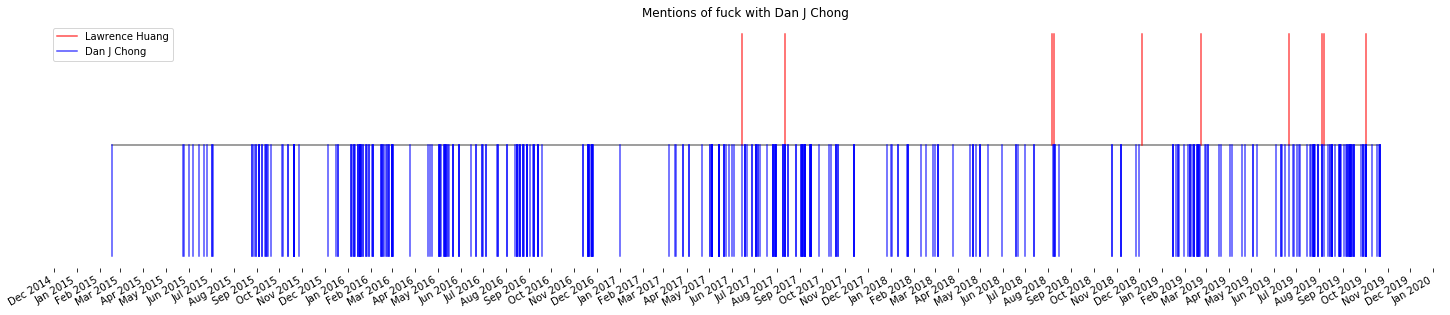

In [24]:
# MODIFY THESE
# =================================
# term_examined = ("holy", "shit")
# term_examined = ("okay")
# term_examined = ("shit")
term_examined = ("fuck")
friend_name = "Dan J Chong"
plot_term_mentions(term_examined, friend_name)